In [1]:
import pandas as pd
import numpy as np
import os
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Tusc5IntegralUtils import *
from Tusc5ImageUtils import *

[2024-08-28 18:48:59,404][INFO]: Connecting Raphael@vfsmdatajoint01.fsm.northwestern.edu:3306
[2024-08-28 18:48:59,938][INFO]: Connected Raphael@vfsmdatajoint01.fsm.northwestern.edu:3306
c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing Data

In [2]:
# '''
# Grabs the fluoresence value from each cell from 'ImageAnalysis folder'

# >>> Need to change directory
# '''


# # Initial Data Import

# directory = '/Users/raphaeltinio/LabAnalysis/ImageAnalysis' # Needs to get to the /ImageAnalysis folder

# stack_names = [f for f in os.listdir(directory) if f != '.DS_Store']

# Cell_Results = pd.DataFrame(columns = ['File', 'Cell', 'Stain', 'X_vals', 'Y_vals'])

# for fname in stack_names:
#     result_directory = directory + "/" + fname + "/results"
    
#     csv_files = [f for f in os.listdir(result_directory) if f.endswith('.csv')] #incase there is a none .csv file for some reason

#     # Grabs number of cells in an image
#     ncells = np.unique([re.search(r'(\d+)(?=\.csv$)', s).group(1) if re.search(r'(\d+)(?=\.csv$)', s) else None for s in csv_files])

#     # Cell Counter
#     if len(Cell_Results) == 0:
#         n_add = 0

#     else:
#         n_add = Cell_Results.Cell.max() + 1 # counts the number of cells after an addition of a z-stack dataframe, so that it keeps counting up 

#     for n in ncells:
#         unique_cell = [f for f in csv_files if "cell" + n + '.csv' in f] # Grabs list of specific cell

#         cell_number = int(n) + n_add

#         for csv in unique_cell:

#             stain_number = csv.split('_')[0]
#             #stain_number = re.findall(r'\d+$', stain_number)[0]

#             single_csv = pd.read_csv(result_directory + '/' + csv, usecols = [1,2])

#             temp_frame = pd.DataFrame({
#                 'File': fname,
#                 'Cell': cell_number,
#                 'Stain': stain_number,
#                 'X_vals': [single_csv['X'].to_list()],
#                 'Y_vals': [single_csv['Y'].to_list()]})

#             Cell_Results = pd.concat([Cell_Results, temp_frame])


# Cell_Results = Cell_Results.reset_index(drop = True)
# Cell_Results['Cell'] = Cell_Results['Cell'].astype('int')
# Cell_Results = Cell_Results.sort_values('Cell')

# # Extracting the first four integers and the following letter into separate columns ({DJID}{Eye})
# Cell_Results['DJID'] = Cell_Results['File'].str.extract(r'(\d{4})').astype(int)
# Cell_Results['Eye'] = Cell_Results['File'].str.extract(r'(\d{4})([A-Za-z])')[1]

# #Renaming Glut1 to GluT1
# Cell_Results['Stain'] = Cell_Results['Stain'].apply(lambda x: 'GluT1' if x == 'Glut1' else x)

# Cell_Results.to_csv('Cell_Results.csv', index = False)

In [3]:
'''
Accepts data from the new image analysis
'''

Cell_Results = pd.read_csv('homo_time_data.csv')
Cell_Results['X_vals'] = Cell_Results['X_vals'].apply(ast.literal_eval) # Makes it so cells containing lists are identifiable as lists by pandas
Cell_Results['Y_vals'] = Cell_Results['Y_vals'].apply(ast.literal_eval)
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip
0,"(14688, 16388, 18340, 20556, 23217, 29307, 391...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False
1,"(5423, 6308, 7726, 9008, 10887, 15027, 18190, ...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False
2,"(67602, 84336, 108497, 132352, 156454, 180970,...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False
3,"(10, 25, 49, 117, 285, 467, 577, 456, 394, 528...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False
4,"(8390, 9000, 9731, 9855, 10701, 11961, 13757, ...",1,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False


## DJID_GEN_Eye Merge

In [4]:
'''
'DJID_GEN_EYES.csv' contains DJIDs which connect DJIDs to genotype and which eye was in the experimental or control group

This code chunk merges that dataframe with Cell_Results


Takes into consideration if file_name has variations on eye types (e.g. RA, LD)
'''

Recorded_Info = pd.read_csv('DJID_GEN_EYES_DURATION.csv')
merged_df = pd.merge(Cell_Results, Recorded_Info[['DJID', 'Genotype', 'Experimental Eye', 'Control Eye', 'Time_Condition']], on='DJID', how='left')
merged_df.loc[merged_df['Eye'].str[0] == merged_df['Experimental Eye'].str[0], 'Group_Type'] = 'Experimental'
merged_df.loc[merged_df['Eye'].str[0] == merged_df['Control Eye'].str[0], 'Group_Type'] = 'Control'
Cell_Results = merged_df.drop(columns=['Experimental Eye', 'Control Eye'])

Cell_Results.loc[Cell_Results['Genotype'] == 'wildtype', 'eGFP_Value'] = False # Making sure wildtype retinas do not have false positive eGFP cells

Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type
0,"(14688, 16388, 18340, 20556, 23217, 29307, 391...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control
1,"(5423, 6308, 7726, 9008, 10887, 15027, 18190, ...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control
2,"(67602, 84336, 108497, 132352, 156454, 180970,...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control
3,"(10, 25, 49, 117, 285, 467, 577, 456, 394, 528...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control
4,"(8390, 9000, 9731, 9855, 10701, 11961, 13757, ...",1,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control


In [5]:
print('STATS BEFORE FILTER')

print('#'*50)
print('DJID:', Cell_Results.DJID.unique())
print('in_rip:', Cell_Results.in_rip.unique())
print('Group_type:', Cell_Results.Group_Type.unique())
print('Time Conditions:', Cell_Results.Time_Condition.unique())
print('Genotype:', Cell_Results.Genotype.unique())
print('#'*50)

print(Cell_Results.groupby('DJID')['Time_Condition'].count()/4)
print('#'*50)

STATS BEFORE FILTER
##################################################
DJID: [3604 3606 3653 3654 3656]
in_rip: [False]
Group_type: ['Control' 'Experimental']
Time Conditions: [30 90 15 60]
Genotype: ['homo']
##################################################
DJID
3604    336.0
3606    172.0
3653    156.0
3654    168.0
3656    358.0
Name: Time_Condition, dtype: float64
##################################################


## Birth Data Merge


In [6]:
'''
Fetching a table to connect DJID to mouse age
Then merging that table to Cell_Results

'''

# DJ query and fetch
init_query = sln_animal.Animal.proj('dob', 'sex') * sln_animal.AnimalEvent * sln_animal.Deceased
birth_data = init_query.proj('dob', 'sex', 'date').fetch(format = 'frame')

# Reseting index and renaming columns
birth_data = birth_data.reset_index().drop(columns = ['event_id'])
birth_data = birth_data.rename(columns = {'animal_id': 'DJID', 'dob': 'birth', 'date': 'death'})

# Changing variables to date time vars
birth_data['birth'] = pd.to_datetime(birth_data['birth'])
birth_data['death'] = pd.to_datetime(birth_data['death'])

# Calculate the difference in days
birth_data['Age_Days'] = (birth_data['death'] - birth_data['birth']).dt.days

# Convert days to months (approximately, assuming ~30.44 days in a month)
birth_data['Age_Months'] = round(birth_data['Age_Days'] / 30.44,1)

# Merge
Cell_Results = Cell_Results.merge(birth_data, how = 'left', on = 'DJID')
Cell_Results = Cell_Results.drop(columns = ['birth', 'death', 'Age_Days'])
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months
0,"(14688, 16388, 18340, 20556, 23217, 29307, 391...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8
1,"(5423, 6308, 7726, 9008, 10887, 15027, 18190, ...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8
2,"(67602, 84336, 108497, 132352, 156454, 180970,...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8
3,"(10, 25, 49, 117, 285, 467, 577, 456, 394, 528...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8
4,"(8390, 9000, 9731, 9855, 10701, 11961, 13757, ...",1,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8


## Slice Separation and ID generation

In [7]:
'''
1) Adds a column to the dataframe which contains the z-stack slice seperation value

2) Adds a cell id

'''
Cell_Results['Slice_Seperation'] = Cell_Results['X_vals'].apply(lambda x: x[1]-x[0])

Cell_Results['Cell'] = Cell_Results.groupby(['file_name', 'mask_id']).ngroup()

In [8]:
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months,Slice_Seperation,Cell
0,"(14688, 16388, 18340, 20556, 23217, 29307, 391...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8,0.15,0
1,"(5423, 6308, 7726, 9008, 10887, 15027, 18190, ...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8,0.15,0
2,"(67602, 84336, 108497, 132352, 156454, 180970,...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8,0.15,0
3,"(10, 25, 49, 117, 285, 467, 577, 456, 394, 528...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.168230,False,homo,30,Control,Male,2.8,0.15,0
4,"(8390, 9000, 9731, 9855, 10701, 11961, 13757, ...",1,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1


Stain: DAPI, Detected peaks at indices: [42]
Stain: eGFP, Detected peaks at indices: [ 8 19 50]
Stain: WGA, Detected peaks at indices: [ 8 48]
Stain: GluT1, Detected peaks at indices: [12 22 34 45]


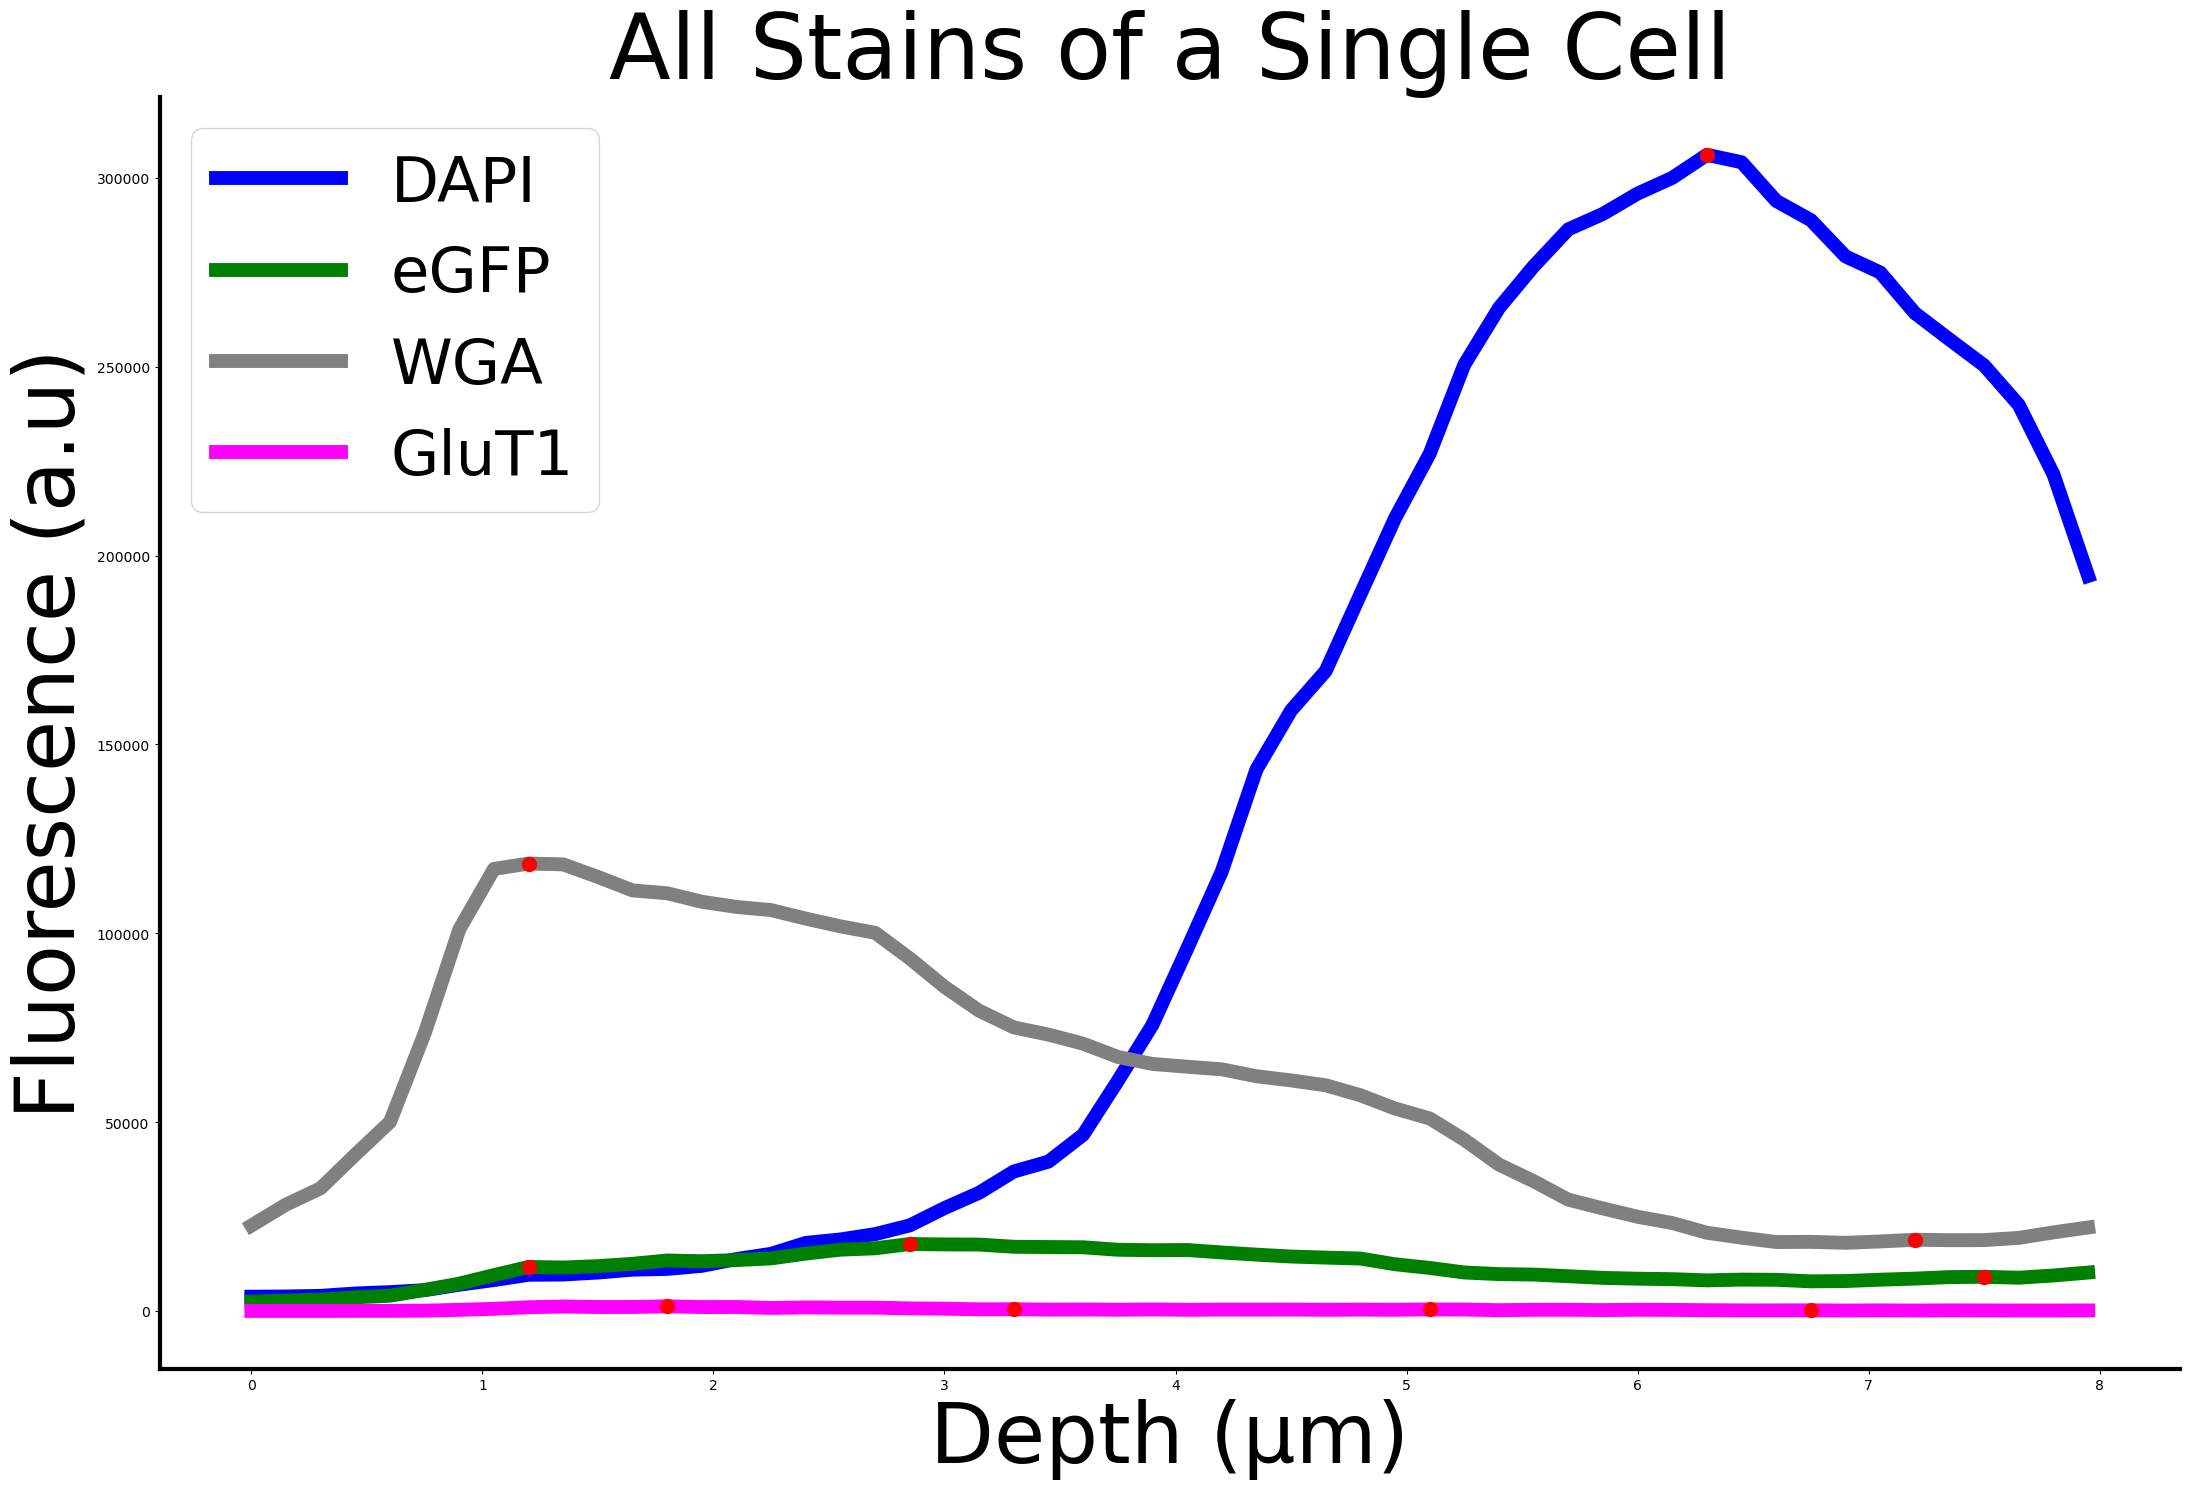

In [9]:
plot_single_cell(Cell_Results.query('Cell == 75'), prominence= 20, distance = 10)

## Filters

In [10]:
'''
Goes through each cell in Cell_Results and calculates peaks

Prominence = 25 was chosen as it experimentally retained the most number of good cells.

'''

# Peak Filter

print(f'Original number of Cells: {len(Cell_Results)/4}')

remove_list = []

for cell_number in Cell_Results['Cell'].unique():
    
    CR_Query = Cell_Results.query('Cell == @cell_number').copy()

    slice_seperation = CR_Query.iloc[0]['Slice_Seperation']

    WGA_min_distance = int(2.25 / slice_seperation) # peaks must be 4 microns away from eachother
    DAPI_min_distance = int(10 / slice_seperation)
    
    index_max = len(CR_Query.iloc[0]['X_vals'])

    WGA_Y_vals = CR_Query.loc[CR_Query['Stain'] == 'WGA']['Y_vals'].iloc[0]
    DAPI_Y_vals = CR_Query.loc[CR_Query['Stain'] == 'DAPI']['Y_vals'].iloc[0]

    peaks_WGA, _ = find_peaks(WGA_Y_vals, prominence= 25, distance = WGA_min_distance)
    peaks_DAPI, _ = find_peaks(DAPI_Y_vals, prominence= 25, distance = DAPI_min_distance)

    '''
    WGA Filters

    '''
    
    # 1) Remove if less than two peaks
    if len(peaks_WGA) < 2:
        remove_list.append(cell_number)
        continue
    

    if peaks_WGA[1] != peaks_WGA[-1] and WGA_Y_vals[peaks_WGA[-1]] > WGA_Y_vals[peaks_WGA[1]]:
        remove_list.append(cell_number)
        continue

    # '''
    # DAPI Filters
    # '''

    if len(peaks_DAPI) < 1:
        remove_list.append(cell_number)
        continue

    elif len(peaks_DAPI) == 1 and peaks_DAPI[0] > peaks_WGA[0] and peaks_DAPI[0] < peaks_WGA[1]:
        pass

    if peaks_DAPI[0] != peaks_DAPI[-1] and DAPI_Y_vals[peaks_DAPI[-1]] > DAPI_Y_vals[peaks_DAPI[1]]:
        remove_list.append(cell_number)

# Removing undesirable cells from main list
remove_list = np.unique(remove_list)
Cell_Results = Cell_Results[~Cell_Results['Cell'].isin(remove_list)]

print(f'Remaining Cells after Filter: {len(Cell_Results)/4}')
print(f'Cell Numbers Removed {remove_list}, count : {len(remove_list)}')

Original number of Cells: 1190.0
Remaining Cells after Filter: 878.0
Cell Numbers Removed [   0    3    7   10   27   28   32   35   36   38   40   42   44   45
   50   53   61   62   67   69   70   77   81   88   93   94   97   98
  104  105  113  114  115  116  117  119  120  121  122  123  124  125
  126  127  128  129  130  133  134  135  136  138  140  141  142  143
  144  145  146  147  148  150  152  153  155  159  162  165  167  168
  169  170  171  172  173  175  176  177  178  180  182  184  186  187
  190  191  193  197  198  199  200  205  207  209  210  215  219  222
  223  227  229  231  232  233  234  237  240  241  242  243  244  245
  246  247  249  250  251  252  255  256  257  259  260  263  264  265
  266  269  271  272  276  278  280  283  284  285  286  288  291  293
  296  308  311  316  317  318  319  321  322  323  326  327  329  334
  339  340  371  379  394  402  408  423  435  441  446  450  471  476
  484  485  494  497  582  590  592  596  598  602  607  6

In [11]:
print('STATS AFTER FILTER')

print('#'*50)
print('DJID:', Cell_Results.DJID.unique())
print('in_rip:', Cell_Results.in_rip.unique())
print('Group_type:', Cell_Results.Group_Type.unique())
print('Time Conditions:', Cell_Results.Time_Condition.unique())
print('Genotype:', Cell_Results.Genotype.unique())
print('#'*50)
print(Cell_Results.groupby('DJID')['Time_Condition'].count()/4)
print('#'*50)

STATS AFTER FILTER
##################################################
DJID: [3604 3606 3653 3654 3656]
in_rip: [False]
Group_type: ['Control' 'Experimental']
Time Conditions: [30 90 15 60]
Genotype: ['homo']
##################################################
DJID
3604    182.0
3606    154.0
3653    128.0
3654    127.0
3656    287.0
Name: Time_Condition, dtype: float64
##################################################


## eGFP Finder (Retired)

In [12]:
# eGFP finder
eGFP_filtered = []
remove_from_eGFP = []

for cell_number in Cell_Results['Cell'].unique():

    CR_Query = Cell_Results.query('Cell == @cell_number').copy()

    slice_seperation = CR_Query.iloc[0]['Slice_Seperation']
    DAPI_min_distance = int(10 / slice_seperation)

    DAPI_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'DAPI']['Y_vals'].iloc[0], prominence= 25, distance = DAPI_min_distance)
    DAPI_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'DAPI', 'Y_vals'].iloc[0])[DAPI_idx[0]]

    # eGFP peak needs to be at least half of DAPI peak to be considered eGFP positive
    eGFP_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'eGFP']['Y_vals'].iloc[0], prominence= 100, distance = 10, height = int(DAPI_peak_val/2))
    eGFP_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'eGFP', 'Y_vals'].iloc[0])[eGFP_idx]

    WGA_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'WGA']['Y_vals'].iloc[0], prominence= 25)
    WGA_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'WGA', 'Y_vals'].iloc[0])[WGA_idx]

    if len(eGFP_peak_val) == 1:

        # If eGFP peak is not within WGA peaks, cell is not considered eGFP positive
        if eGFP_idx < WGA_idx[0] or eGFP_idx > WGA_idx[1]:
            remove_from_eGFP.append(cell_number)
        
        # If eGFP is not at least 1/2 the size of 
        if eGFP_peak_val > WGA_peak_val[1]/2:
            eGFP_filtered.append(cell_number)


eGFP_filtered = list(set(eGFP_filtered))
eGFP_filtered = sorted([i for i in eGFP_filtered if i not in remove_from_eGFP])

print(f'Cells with eGFP: {eGFP_filtered}, count: {len(eGFP_filtered)}')

# Labeling Cells T5 Positive or Negative
Cell_Results['T5'] = 'Negative'
Cell_Results.loc[Cell_Results['Cell'].isin(eGFP_filtered), 'T5'] = 'Positive'

Cells with eGFP: [342, 364, 375, 382, 405, 427, 620, 627, 633, 641, 661, 1125, 1144, 1145, 1147, 1159, 1161, 1179], count: 18


In [13]:
# Comparison between
positive_old_identifier = np.array(eGFP_filtered)
positive_new_identifier = Cell_Results.loc[Cell_Results['eGFP_Value'] == True].Cell.unique()
print('Number of cells in old eGFP finder', len(positive_old_identifier))
print('Number of cells in new eGFP finder', len(positive_new_identifier))
print('Percent of old cells from old eGFP finder in new eGFP finder:', np.isin(positive_old_identifier, positive_new_identifier).sum()/ len(np.isin(positive_old_identifier, positive_new_identifier)) * 100, '%')



Number of cells in old eGFP finder 18
Number of cells in new eGFP finder 187
Percent of old cells from old eGFP finder in new eGFP finder: 83.33333333333334 %


In [14]:
Cell_Results

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months,Slice_Seperation,Cell,T5
4,"(8390, 9000, 9731, 9855, 10701, 11961, 13757, ...",1,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
5,"(6807, 8410, 10315, 11402, 13114, 14515, 15068...",1,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
6,"(98974, 122420, 144750, 154462, 156307, 132606...",1,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
7,"(72, 197, 395, 564, 794, 786, 664, 500, 450, 5...",1,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
8,"(20121, 22253, 24967, 28333, 31792, 43037, 584...",3,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.354524,False,homo,30,Control,Male,2.8,0.15,2,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,"(4, 3, 5, 15, 16, 145, 145, 459, 1001, 1897, 2...",120,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.870239,False,homo,60,Experimental,Female,1.9,0.15,1188,Negative
4756,"(1324, 1480, 1478, 1565, 1801, 2035, 1976, 258...",123,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.585781,False,homo,60,Experimental,Female,1.9,0.15,1189,Negative
4757,"(751, 802, 771, 951, 918, 1109, 1131, 1422, 17...",123,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.585781,False,homo,60,Experimental,Female,1.9,0.15,1189,Negative
4758,"(3700, 4571, 5385, 6865, 8194, 11808, 14736, 2...",123,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.585781,False,homo,60,Experimental,Female,1.9,0.15,1189,Negative


## Summary of Cell_Results

In [15]:
'''
Sanity Check


'''

print('Genotype', Cell_Results['Genotype'].unique())
print('T5 Labelling', Cell_Results['Stain'].unique())
print('eGFP Types', Cell_Results['eGFP_Value'].unique())

print('\n')
print('###'*12)
print('\n')

'''
Summary of mouse information
'''

def extract_before_underscore(input_string):
    parts = input_string.split("_", 1)
    if len(parts) > 1:
        return parts[0]
    
eyes = Cell_Results['file_name'].apply(extract_before_underscore).unique()

def extract_first_four_integers(input_string):
    # Find all substrings of consecutive digits
    integers = re.findall(r'\d+', input_string)
    
    # Convert the found substrings into integers
    integers = [int(i) for i in integers]
    
    # Return the first four integers
    return integers[:4][0]

animals = list(map(extract_first_four_integers, eyes))
animals = pd.Series(animals).unique() # Extracting the unqiue values

left = 0
right = 0

for i in eyes:
    if 'R' in i:
        right += 1
    if 'L' in i:
        left +=1

positive_count = Cell_Results['eGFP_Value'].value_counts()[True]/4
total = (len(Cell_Results))/4


###
print(f'Number of mice: {len(animals)}')
print(f'Mice DJIDs: {animals}')
print(f'Number of eyes: {len(eyes)}, Left = {left} R = {right}')

###
print('\n')
print('###'*12)
print('\n')

###
print('Number of Cells', Cell_Results['Cell'].count()/4)
print('eGFP Positive', (Cell_Results.groupby('eGFP_Value').size()/4)[True])
print('eGFP Negative', (Cell_Results.groupby('eGFP_Value').size()/4)[False])
print('Positive over Total Percentage', positive_count/total*100)

Genotype ['homo']
T5 Labelling ['DAPI' 'eGFP' 'WGA' 'GluT1']
eGFP Types [ True False]


####################################


Number of mice: 5
Mice DJIDs: [3604 3606 3653 3654 3656]
Number of eyes: 5, Left = 2 R = 3


####################################


Number of Cells 878.0
eGFP Positive 187.0
eGFP Negative 691.0
Positive over Total Percentage 21.298405466970387


In [16]:
Cell_Results.columns

Index(['Y_vals', 'mask_id', 'Stain', 'X_vals', 'file_name', 'DJID', 'Eye',
       'eGFP_Value', 'eGFP_Raw_Intensity', 'in_rip', 'Genotype',
       'Time_Condition', 'Group_Type', 'sex', 'Age_Months', 'Slice_Seperation',
       'Cell', 'T5'],
      dtype='object')

In [17]:
Cell_Results.groupby(['Genotype','DJID','sex'])['Age_Months'].unique()

Genotype  DJID  sex   
homo      3604  Male      [2.8]
          3606  Male      [2.8]
          3653  Male      [1.9]
          3654  Male      [1.9]
          3656  Female    [1.9]
Name: Age_Months, dtype: object

# Calculations

## Defining Functions

In [18]:
'''
Function: Calculating WGA Peaks

Creates columns: WGA_Middle_Indices, Length (um)

'''

def WGA_Peaks_Finder(dataframe, prom_val:int = 25):

    # Function to find WGA peaks for each cell (via .groupby)
    def find_peaks_in_cell(cell_df):
        # Filter rows where Stain is 'WGA'
        df_WGA = cell_df.loc[cell_df['Stain'] == 'WGA']
        
        slice_seperation = df_WGA.iloc[0]['Slice_Seperation']
        WGA_min_distance = int(2.25 / slice_seperation) 
        WGA_peak_indicies = find_peaks(df_WGA['Y_vals'].iloc[0], prominence = prom_val, distance = WGA_min_distance)[0]


        return WGA_peak_indicies

    # Apply the peak finder function across cells grouped by 'Cell'
    grouped = dataframe.groupby('Cell')
    slice_separation = grouped['Slice_Seperation'].first().iloc[0]

    grouped_WGA_indices = grouped.apply(find_peaks_in_cell).reset_index().rename(columns={0: 'WGA_Middle_Indices'})    # Reset index to flatten the DataFrame and rename



    grouped_WGA_indices['Length'] = grouped_WGA_indices['WGA_Middle_Indices'].apply(lambda x: (x[1] - x[0]) * slice_separation)

    #Merge the peak indices back into the original DataFrame
    result_df = pd.merge(dataframe, grouped_WGA_indices, on='Cell', how='left')

    return result_df


In [19]:
Cell_Results

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months,Slice_Seperation,Cell,T5
4,"(8390, 9000, 9731, 9855, 10701, 11961, 13757, ...",1,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
5,"(6807, 8410, 10315, 11402, 13114, 14515, 15068...",1,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
6,"(98974, 122420, 144750, 154462, 156307, 132606...",1,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
7,"(72, 197, 395, 564, 794, 786, 664, 500, 450, 5...",1,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.183067,False,homo,30,Control,Male,2.8,0.15,1,Negative
8,"(20121, 22253, 24967, 28333, 31792, 43037, 584...",3,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3604R_GLUT1_WGA_0001,3604,R,True,3.354524,False,homo,30,Control,Male,2.8,0.15,2,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,"(4, 3, 5, 15, 16, 145, 145, 459, 1001, 1897, 2...",120,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.870239,False,homo,60,Experimental,Female,1.9,0.15,1188,Negative
4756,"(1324, 1480, 1478, 1565, 1801, 2035, 1976, 258...",123,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.585781,False,homo,60,Experimental,Female,1.9,0.15,1189,Negative
4757,"(751, 802, 771, 951, 918, 1109, 1131, 1422, 17...",123,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.585781,False,homo,60,Experimental,Female,1.9,0.15,1189,Negative
4758,"(3700, 4571, 5385, 6865, 8194, 11808, 14736, 2...",123,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3656R_GLUT1_WGA_0005,3656,R,False,1.585781,False,homo,60,Experimental,Female,1.9,0.15,1189,Negative


In [20]:
'''
Function: Calculates "Top" and "Bottom" INDICES to be used for integral boundaries

Creates columns: WGA_Top_Indices, WGA_Bottom_Indices
'''

def Top_Bottom_Indices(dataframe, microns_extension: float = 1.5):
    # Grouping / Getting Slice Separation / Calculating peaks
    grouped = dataframe.groupby('Cell')
    slice_separation = grouped['Slice_Seperation'].first()
    max_idx = Cell_Results.groupby('Cell')['X_vals'].first().apply(lambda x: len(x))
    first_peaks = grouped['WGA_Middle_Indices'].apply(lambda x: x.iloc[0] if len(x) > 0 else [np.nan, np.nan])

    # Calculate index offset for each cell based on the slice separation
    index_offset = (microns_extension / slice_separation).fillna(0).astype(int)

    # Separate the peak indices
    l_middle = first_peaks.apply(lambda x: x[0] if len(x) > 0 else np.nan)
    r_middle = first_peaks.apply(lambda x: x[1] if len(x) > 1 else np.nan)

    # Calculate modified indices
    l_top = l_middle - index_offset
    r_bot = r_middle + index_offset

    # Prepare to merge corrections for indices exceeding boundaries
    max_idx = grouped['X_vals'].apply(lambda x: len(x.iloc[0]))

    # Adjust indices to ensure they do not exceed the size of the array
    l_top = np.maximum(l_middle - index_offset, 0)
    r_bot = np.minimum(r_bot, max_idx)

    # Creating DataFrame for merging
    idx_df = pd.DataFrame({
        'Cell': grouped.size().index,  # Assures alignment with group keys
        'WGA_Top_Indices': list(zip(l_top, l_middle)),
        'WGA_Bottom_Indices': list(zip(r_middle, r_bot))
    })

    # Merge adjusted index data back into the original DataFrame
    result_df = pd.merge(dataframe, idx_df, on='Cell', how='left')

    return result_df

In [21]:
'''
Function: Calculates "Top", "Middle", "Bottom" INTEGRALS

Creates columns: Middle_Integral, Top_Integral, Bottom_Integral
'''

def TopMidBot_Integrals(dataframe):
    

    # Allows you to calculate integrals through .apply()
    def integral_calculator(arr1, arr2, integral_section:str = 'Middle'):

        if integral_section == 'Middle':

            peak_yvals = np.array(arr1)[arr2[0]:arr2[1]]

        if integral_section == 'Top':

            peak_yvals = np.array(arr1)[arr2[0]:arr2[1]] 

        if integral_section == 'Bottom': 

            peak_yvals = np.array(arr1)[arr2[0]:arr2[1]]
        return peak_yvals


    for section in ['Middle', 'Top', 'Bottom']:
        dataframe[f'{section}_Integral'] = dataframe.apply(lambda x: np.sum(integral_calculator(x['Y_vals'], x[f'WGA_{section}_Indices'], integral_section = section)), axis =1)
    
    return dataframe

In [22]:
'''
Function: Calculates "Top", "Bottom" INTEGRAL RATIOS

# Calculating the ratio of Glut1 over WGA (normalization) .5 microns about the WGA peaks

Creates columns: [WGA or GluT1]_[Top or Bot]_Surface_Integral
'''

def Surface_Integrals(dataframe):
    # Initialize a list to store results dataframes for each group
    results = []

    # Group by 'Cell' and process each group
    for (cell, group) in dataframe.groupby('Cell'):
        # Filter for WGA and GluT1 stains
        df_WGA = group.loc[group['Stain'] == 'WGA']
        df_GluT1 = group.loc[group['Stain'] == 'GluT1']


        peak_indices = df_WGA['WGA_Middle_Indices'].iloc[0]
        x_vals = df_WGA['X_vals'].iloc[0]

        # Compute slice separation and radius offset
        slice_separation = group['Slice_Seperation'].iloc[0]
        radius = 0.5
        idx_offset = int(radius / slice_separation)

        # Define borders based on peak indices and radius offset
        top_lborder = max(peak_indices[0] - idx_offset, 0)
        top_rborder = min(peak_indices[0] + idx_offset, len(x_vals))
        bottom_lborder = max(peak_indices[1] - idx_offset, 0)
        bottom_rborder = min(peak_indices[1] + idx_offset, len(x_vals))

        # Calculate integrals for 'GluT1' and 'WGA'
        top_surface_integral_GluT1 = np.sum(df_GluT1.iloc[0]['Y_vals'][top_lborder:top_rborder])
        bottom_surface_integral_GluT1 = np.sum(df_GluT1.iloc[0]['Y_vals'][bottom_lborder:bottom_rborder]) 
        top_surface_integral_WGA = np.sum(df_WGA.iloc[0]['Y_vals'][top_lborder:top_rborder])
        bottom_surface_integral_WGA = np.sum(df_WGA.iloc[0]['Y_vals'][bottom_lborder:bottom_rborder+1])

        # Ratio calculations
        Top_G_over_W = top_surface_integral_GluT1 / top_surface_integral_WGA
        Bottom_G_over_W = bottom_surface_integral_GluT1 / bottom_surface_integral_WGA

        # Append results as a DataFrame to list
        results.append(pd.DataFrame({
            'Cell': [cell],
            'GluT1_Top_Surface_Integral': [top_surface_integral_GluT1],
            'GluT1_Bot_Surface_Integral': [bottom_surface_integral_GluT1],
            'WGA_Top_Surface_Integral': [top_surface_integral_WGA],
            'WGA_Bot_Surface_Integral': [bottom_surface_integral_WGA],
            'Top_Surface_Ratio': [Top_G_over_W],
            'Bot_Surface_Ratio': [Bottom_G_over_W]
        }))

    # Concatenate all results into a single DataFrame
    results_df = pd.concat(results, ignore_index=True)

    # Merge adjusted index data back into the original DataFrame

    dataframe = dataframe.merge(results_df, on='Cell', how='left')
    
    return dataframe

In [23]:
"""
Function: Reshapes columns, so that each group has a column with '{Stain}_{Integral_Type}'. 4 x 3 = 12 columns are added
"""

def Reshape_Integrals(dataframe):

    # Make pivot table
    pivot_df = dataframe.pivot_table(
        index=['Cell'], 
        columns='Stain',
        values=['Middle_Integral', 'Top_Integral', 'Bottom_Integral'],
        aggfunc='first' 
    )

    # Flatten the multi-level column headers and format them
    pivot_df.columns = [f'{col[1]}_{col[0]}' for col in pivot_df.columns.values]

    pivot_df.reset_index(inplace=True) # Cell is a column used to merge 

    result_df = pd.merge(dataframe, pivot_df)

    return result_df

In [24]:
Cell_Results_Calcs = Cell_Results.copy()

# These functions find indices
Cell_Results_Calcs = WGA_Peaks_Finder(Cell_Results_Calcs)
Cell_Results_Calcs = Top_Bottom_Indices(Cell_Results_Calcs)

# These functions calculate integrals using the index boundaries
Cell_Results_Calcs = TopMidBot_Integrals(Cell_Results_Calcs)
Cell_Results_Calcs = Reshape_Integrals(Cell_Results_Calcs)
Cell_Results_Calcs = Surface_Integrals(Cell_Results_Calcs)

## Export

In [25]:
'''
Making new dataframe for export
- Keeps certain columns
- Renames columns
- Mapping column categories to new names (e.g. eGFP Positive -> 1)
'''

# Columns to Keep
keep_cols = ['DJID', 'Genotype', 'Eye', 'sex', 'Age_Months', 'eGFP_Value', 'Group_Type', 'in_rip', 'Length', 'Time_Condition',
             'GluT1_Top_Surface_Integral', 'GluT1_Bot_Surface_Integral', 'WGA_Top_Surface_Integral', 'WGA_Bot_Surface_Integral',
             'GluT1_Top_Integral', 'GluT1_Middle_Integral', 'GluT1_Bottom_Integral',
             'WGA_Top_Integral', 'WGA_Middle_Integral', 'WGA_Bottom_Integral']

# Columns to rename
renamed_cols = {'sex': 'Sex',
                'Length': 'Length_um',
                'in_rip': 'In_Rip',
                'Group_Type' :'Experimental_Condition'}

Export_df = Cell_Results_Calcs.groupby('Cell').first().loc[:, keep_cols].reset_index(drop = True)
Export_df = Export_df.rename(columns = renamed_cols)

# Remapping values
Export_df['eGFP_Value'] = Export_df['eGFP_Value'].astype(int)
Export_df['In_Rip'] = Export_df['In_Rip'].astype(int)

Exp_Con_map = {'Experimental': 'Light Flicker', 'Control': 'Dark'}
Export_df['Experimental_Condition'] = Export_df['Experimental_Condition'].map(Exp_Con_map)#.fillna(Export_df['Experimental_Condition'])

# Checking for NA vals
if Export_df.isna().sum().sum() > 0:
    print('There are NA values, check for problems')

Export_df

,DJID,Genotype,Eye,Sex,Age_Months,eGFP_Value,Experimental_Condition,In_Rip,Length_um,Time_Condition,GluT1_Top_Surface_Integral,GluT1_Bot_Surface_Integral,WGA_Top_Surface_Integral,WGA_Bot_Surface_Integral,GluT1_Top_Integral,GluT1_Middle_Integral,GluT1_Bottom_Integral,WGA_Top_Integral,WGA_Middle_Integral,WGA_Bottom_Integral
0,3604,homo,R,Male,2.8,1,Dark,0,2.70,30,3400,2196,815442,390650,1228,8785,3106,520606,1367248,500967
1,3604,homo,R,Male,2.8,1,Dark,0,5.55,30,5141,1738,969221,377866,1595,25514,1895,480988,2569341,486597
2,3604,homo,R,Male,2.8,0,Dark,0,4.80,30,4726,3451,899635,430962,1549,16368,2452,359102,2170974,533661
3,3604,homo,R,Male,2.8,0,Dark,0,2.55,30,883,468,102877,189118,2108,1884,459,199924,341142,255896
4,3604,homo,R,Male,2.8,1,Dark,0,6.60,30,2192,290,671069,165911,552,17842,151,446687,2112894,125269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,3656,homo,R,Female,1.9,0,Light Flicker,0,4.65,60,12440,6048,312165,27237,5246,76526,2194,242628,527191,11210
874,3656,homo,R,Female,1.9,1,Light Flicker,0,4.65,60,6065,19591,878618,110070,1871,178347,6974,669578,1550715,44202
875,3656,homo,R,Female,1.9,0,Light Flicker,0,4.05,60,19925,17245,811411,121019,8096,131482,10685,677386,1273539,86228
876,3656,homo,R,Female,1.9,0,Light Flicker,0,3.30,60,22136,39237,814106,191550,8756,181870,44699,611217,1438034,257940


In [26]:
Export_df = Export_df.loc[Export_df['Genotype'] != 'wildtype']
Export_df.to_csv('homo_time_processed.csv', index = False)